In [1]:
from wfmread import wfmread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

ch1 = wfmread('data/timing_resolution/800_b6_pre_7-23-2015106_Ch1.wfm')
ch2 = wfmread('data/timing_resolution/800_b6_pre_7-23-2015106_Ch2.wfm')

In [2]:
def first_peak(waveform):
    pedestal = np.mean(waveform[0:200])
    # Iterate through the voltages looking for the first peak (v>3 sig)
    deviation = np.std(waveform[0:200])
    condition = pedestal - 6*deviation
    window, step = 100, 20
    endpoint = len(waveform)-1
    found_peak = False
    for i in range(200, len(waveform), step):
        look = waveform[i:min(i+100,endpoint)].min()
        if look < condition:
            peakAt = np.argwhere(waveform==look)[0][0]
            found_peak = True
            break
    if not found_peak:
        return -1, (-1,-1), -1, -1
    # This will likely find the leading edge, now refine
    peakAt = waveform[int(peakAt-window/2):int(peakAt+window/2)].argmin()+int(peakAt-window/2) 
    peak = waveform[peakAt]
    # Starting at peakAt go left until peak-ped, linear extrapolation
    v_edge = (pedestal - (pedestal-peak)*0.20)
    for idx, v in reversed(list(enumerate(waveform[0:peakAt]))):
        if v > v_edge: #crossed the point
            m = waveform[idx+1]-waveform[idx]
            b = waveform[idx]-m*idx
            g = lambda y: (y-b)/m
            edge = (g(v_edge), v_edge)
            break
    
    return peakAt, edge, pedestal, deviation

first_peak(ch1.wflist[1])

(524,
 (515.05600000000004, -0.0069792004939913752),
 0.0011760000832378875,
 0.00079159591251189816)

<IPython.core.display.Javascript object>


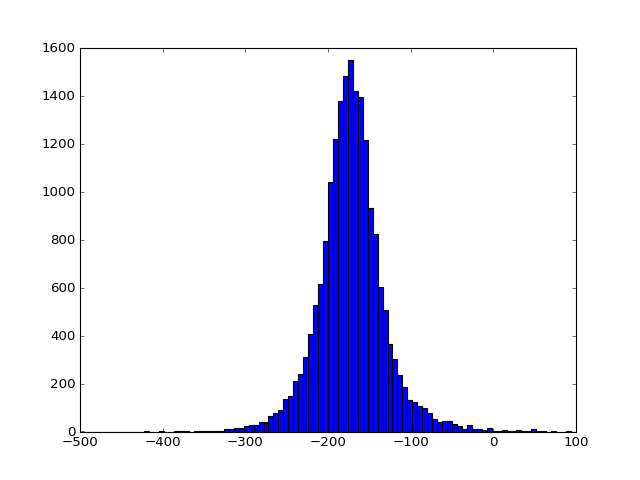

In [8]:
def delta_t(wf1, wf2):
    peak1, edge1, ped1, dev1 = first_peak(wf1)
    peak2, edge2, ped2, dev2 = first_peak(wf2)
    if (peak1 != -1) and (peak2 != -1):
        dt = edge1[0] - edge2[0]
    else:
        dt = -100
    
    return dt

dt = []
for one, two in zip(ch1.wflist, ch2.wflist):
    dt.append(delta_t(one, two))
dt = np.array(dt)
dt *= 50 #units
plt.hist(dt, bins=100, range=(-500, 100), log=False)
plt.show()

<IPython.core.display.Javascript object>


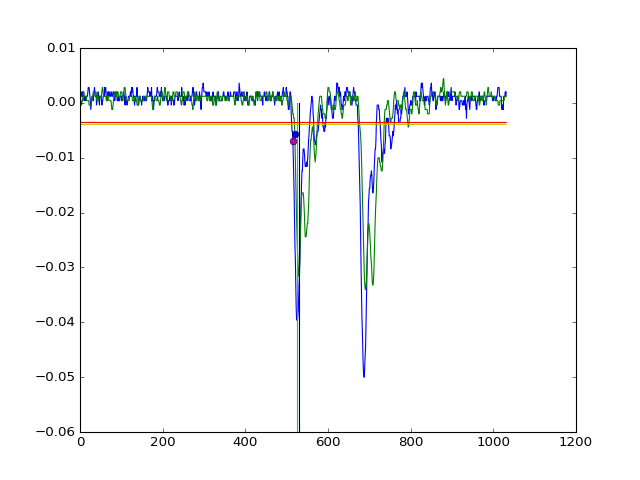

In [7]:
binsize=1
x = np.arange(0,binsize*len(ch1.wflist[1]),binsize)
plt.plot(x, ch1.wflist[1])
plt.plot(x, ch2.wflist[1])
# Pedestal line, peak, and window
peak, edge, ped, dev = first_peak(ch1.wflist[1])
plt.plot(x, np.zeros(len(x))+ped-6*dev) # Pedestal Line
plt.plot((peak, peak),(0, -0.06))
plt.plot(edge[0],edge[1],'o')


peak, edge, ped, dev = first_peak(ch2.wflist[1])
plt.plot(x, np.zeros(len(x))+ped-6*dev) # Pedestal Line
plt.plot((peak, peak),(0, -0.06))
plt.plot(edge[0],edge[1],'o')


plt.show()